In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import scipy

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid")

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,586206408508229439,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",2,4,False
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,586206408508229439,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,5,False
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,586206408508229439,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,586206408508229439,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,586206408508229439,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122689,8e301e72-344d-4331-89bc-4dc1edca20fe,-849763933089140317,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
122690,8e301e72-344d-4331-89bc-4dc1edca20fe,-849763933089140317,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
122691,8e301e72-344d-4331-89bc-4dc1edca20fe,-849763933089140317,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
122692,8e301e72-344d-4331-89bc-4dc1edca20fe,-849763933089140317,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False


In [5]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

In [6]:
no_mod_df = no_hardocoded_df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

## Aggregated Analysis

### User intent impact on toxicity

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


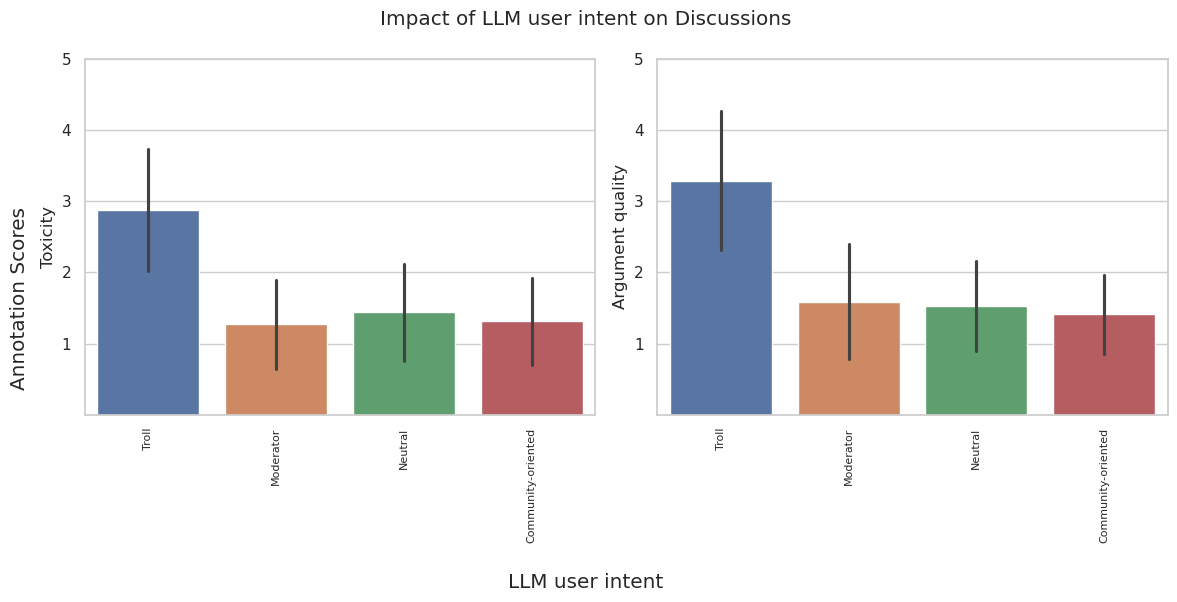

In [7]:
tasks.graphs.plot_metrics_barplots(
    df=no_hardocoded_df,
    group_by_col="intent",
    group_by_col_label="LLM user intent",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


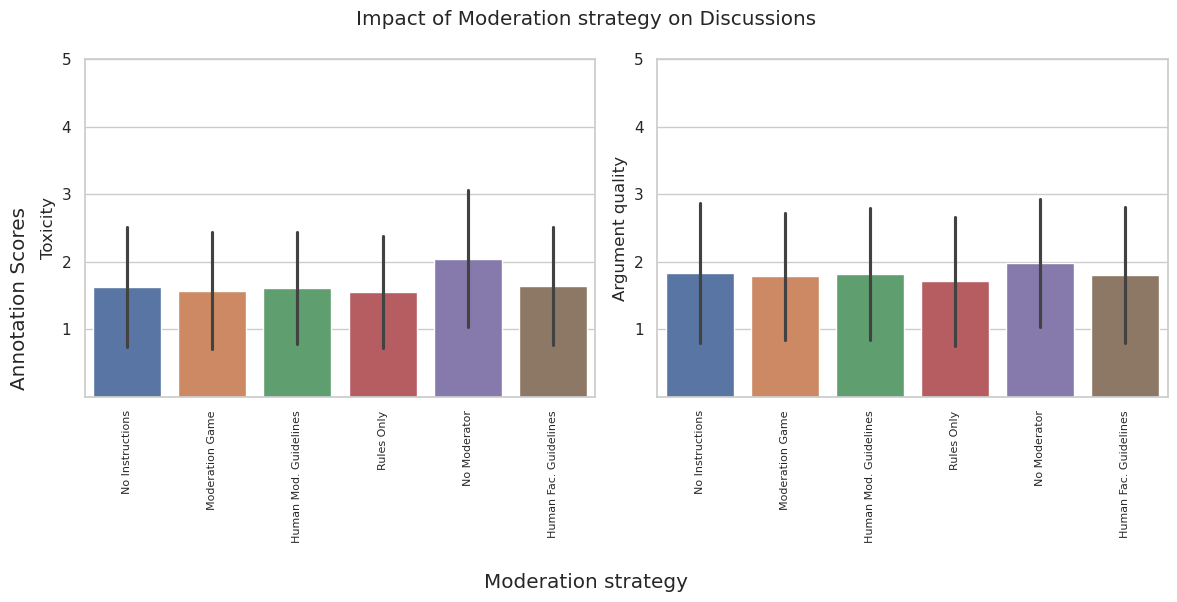

In [8]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="conv_variant",
    group_by_col_label="Moderation strategy",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/model_barplot.png


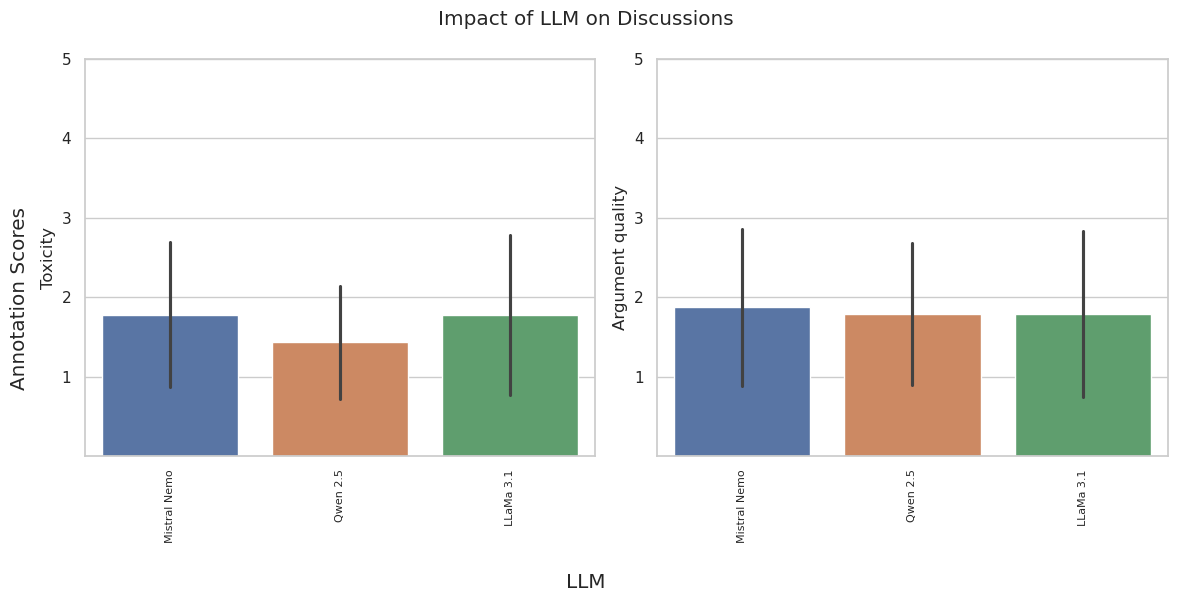

In [9]:
tasks.graphs.plot_metrics_barplots(
    df=no_mod_df,
    group_by_col="model",
    group_by_col_label="LLM",
    metrics=METRICS,
    yticks_list=YTICKS_LIST,
)
tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "model_barplot.png")
plt.show()

## Toxicity by model

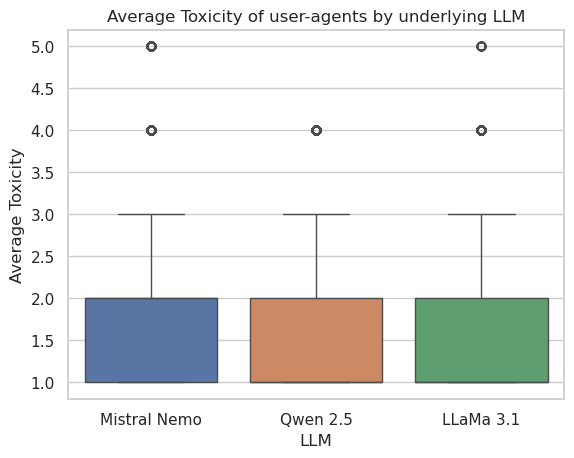

In [10]:
sns.boxplot(data=no_mod_df, x="model", y="Toxicity", hue="model")
plt.title("Average Toxicity of user-agents by underlying LLM")
plt.ylabel("Average Toxicity")
plt.xlabel("LLM")
plt.legend('', frameon=False)
plt.show()

In [11]:
groups = [
    no_mod_df[no_mod_df.model == model].Toxicity.values
    for model in no_mod_df.model.unique()
]
scipy.stats.f_oneway(*groups)

F_onewayResult(statistic=722.2812217531188, pvalue=1.04900741238967e-309)

In [12]:
sp.posthoc_ttest(
        no_mod_df, val_col="Toxicity", group_col="model", p_adjust="holm"
)

,Mistral Nemo,Qwen 2.5,LLaMa 3.1
Mistral Nemo,1.000000e+00,5.762806e-293,5.706501e-01
Qwen 2.5,5.762806e-293,1.000000e+00,3.645316e-226
LLaMa 3.1,5.706501e-01,3.645316e-226,1.000000e+00


In [13]:
[
no_mod_df[no_mod_df.model == model].Toxicity.mean()
for model in no_mod_df.model.unique()
]

[1.78098223615465, 1.4371403912543153, 1.7749858836815358]

## Goad

In [14]:
trolls_exist = (
    full_df.groupby("conv_id")["intent"]
    .apply(lambda x: np.any(x == "Troll"))
    .reset_index()
)
trolls_exist = trolls_exist.rename(columns={"intent": "trolls_exist"})
trolls_exist

,conv_id,trolls_exist
0,01336d04-f98a-46ec-8b1b-1eabd44f369f,False
1,028f869d-cf12-444a-aefc-62f8b6294acd,True
2,04a24daf-ae9b-48bf-b7c2-c5dcd9252c24,True
3,0594f5fe-3bef-4642-8bb7-9ac356f44acb,False
4,095f8e2c-4c6b-45d3-983b-c0a836cd1d4e,True
...,...,...
137,f7221fe4-3eac-42f2-937a-1dacbbe72395,True
138,f8085173-8cbf-4c15-a9e8-713c40539bdd,False
139,fce13b53-ae50-47b2-b70e-1de66f31a8bf,True
140,fdb670f7-dd7e-4222-8f5e-e3c6a8fccff4,True


In [15]:
trolls_df = no_mod_df.merge(trolls_exist, on="conv_id")

# exclude troll posts to check if other comments become more toxic
trolls_df = trolls_df[trolls_df.intent != "Troll"]

trolls_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened,trolls_exist
22,75173c9d-9d25-4389-93d9-6fd7978e30b8,2139351564200983786,3,No Instructions,Mistral Nemo,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"@CryptoBro89, you're the one missing the point...",3,3,False,True
23,75173c9d-9d25-4389-93d9-6fd7978e30b8,2139351564200983786,3,No Instructions,Mistral Nemo,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"@CryptoBro89, you're the one missing the point...",3,3,False,True
24,75173c9d-9d25-4389-93d9-6fd7978e30b8,2139351564200983786,3,No Instructions,Mistral Nemo,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"@CryptoBro89, you're the one missing the point...",3,3,False,True
25,75173c9d-9d25-4389-93d9-6fd7978e30b8,2139351564200983786,3,No Instructions,Mistral Nemo,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"@CryptoBro89, you're the one missing the point...",3,3,False,True
26,75173c9d-9d25-4389-93d9-6fd7978e30b8,2139351564200983786,3,No Instructions,Mistral Nemo,RebelCoder07,You are a human participating in an online cha...,False,Neutral,"@CryptoBro89, you're the one missing the point...",3,3,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47207,8e301e72-344d-4331-89bc-4dc1edca20fe,1099759677826974022,11,Human Fac. Guidelines,Qwen 2.5,ReclusivePoet31,You are a human participating in an online cha...,False,Neutral,"I agree, the combination is crucial. In my com...",1,1,False,False
47208,8e301e72-344d-4331-89bc-4dc1edca20fe,1099759677826974022,11,Human Fac. Guidelines,Qwen 2.5,ReclusivePoet31,You are a human participating in an online cha...,False,Neutral,"I agree, the combination is crucial. In my com...",1,1,False,False
47209,8e301e72-344d-4331-89bc-4dc1edca20fe,1099759677826974022,11,Human Fac. Guidelines,Qwen 2.5,ReclusivePoet31,You are a human participating in an online cha...,False,Neutral,"I agree, the combination is crucial. In my com...",1,1,False,False
47210,8e301e72-344d-4331-89bc-4dc1edca20fe,1099759677826974022,11,Human Fac. Guidelines,Qwen 2.5,ReclusivePoet31,You are a human participating in an online cha...,False,Neutral,"I agree, the combination is crucial. In my com...",1,1,False,False


In [16]:
scipy.stats.ttest_ind(
    trolls_df[trolls_df.trolls_exist].Toxicity.values,
    trolls_df[~trolls_df.trolls_exist].Toxicity.values,
)

TtestResult(statistic=38.90201975911648, pvalue=0.0, df=38652.0)

In [17]:
scipy.stats.ttest_ind(
    trolls_df[trolls_df.trolls_exist]["Argument Quality"].values,
    trolls_df[~trolls_df.trolls_exist]["Argument Quality"].values,
)

TtestResult(statistic=22.20048035224982, pvalue=1.6239328757197035e-108, df=38652.0)

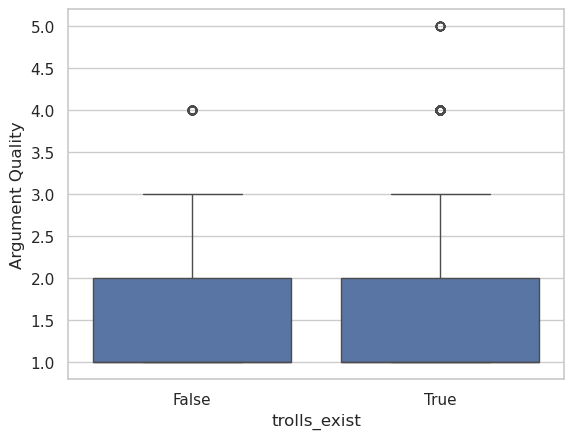

In [18]:
sns.boxplot(data=trolls_df, x="trolls_exist", y="Argument Quality")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_troll_comparison.png


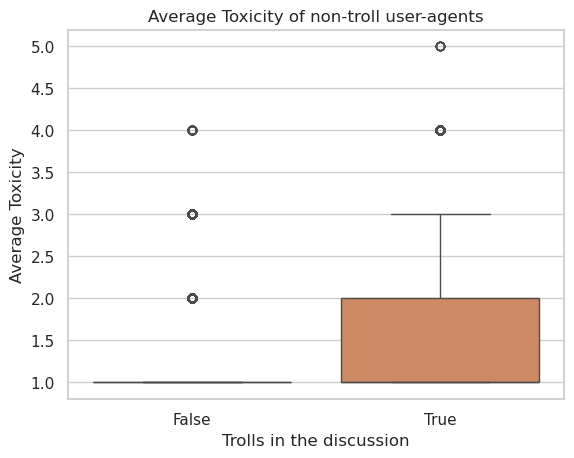

In [19]:
sns.boxplot(data=trolls_df, x="trolls_exist", y="Toxicity", hue="trolls_exist")
plt.title("Average Toxicity of non-troll user-agents")
plt.ylabel("Average Toxicity")
plt.xlabel("Trolls in the discussion")
plt.legend('', frameon=False)
tasks.graphs.save_plot(
    path=tasks.constants.GRAPH_OUTPUT_DIR
    / "toxicity_troll_comparison.png"
)
plt.show()

In [20]:
trolls_df[trolls_df.trolls_exist].Toxicity.mean(), trolls_df[
    ~trolls_df.trolls_exist
].Toxicity.mean()

(1.4935167843250252, 1.2062442607897153)

In [21]:
trolls_df[trolls_df.trolls_exist]["Argument Quality"].mean(), trolls_df[
    ~trolls_df.trolls_exist
]["Argument Quality"].mean()

(1.544806223887048, 1.3908172635445362)